In [1]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
import scipy as sp
import copy
import os
from copy import deepcopy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.prep_data import *

In [3]:
df = pd.read_csv("../data/data.csv")

In [4]:
df.shape

(4727520, 13)

In [5]:
df['Hour'] = df['Tmstamp'].astype(str).str.split(":").str[0].astype(int)
df['Minute'] = df['Tmstamp'].astype(str).str.split(":").str[1].astype(int)
df['T'] = ((df['Day'] - 1) * 144) + (df['Hour'] * 6) + (df['Minute'] // 10)
df = df.sort_values(["T", "TurbID"]).reset_index(drop=True)

In [6]:
split1 = int(df.shape[0]*0.7)
split2 = int(df.shape[0]*0.9)
train = df.iloc[:split1] # 70%
validate = df.iloc[split1:split2] # 10%
test = df.iloc[split2:] # 20%

In [7]:
mask = mask_data(train, base_mask=None, experiment=Experiment.RANDOM, size = 0.01)

In [8]:
train.isna().any(axis=1).sum()

np.int64(44269)

In [9]:
train_input = deepcopy(train)
train_input.loc[~mask, "Patv"] = np.nan
train["isTest"] = train_input.isna().any(axis=1) & train.notna().all(axis=1)

/tmp/ipykernel_18397/324730543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["isTest"] = train_input.isna().any(axis=1) & train.notna().all(axis=1)


In [10]:
train_input.isna().any(axis=1).sum()

np.int64(76775)

Setup: We have ground truth data over a graph but some of the values were missing and have been linearly interpolated. That means we can treat those interpolated values as having noise x' = x + n. We can extract the original x by doing regularization.

However because we don't have the ground truth of the missing values, there is no way to validate the performance of the regularizer. 

Option A: Add noise to the true values but not the interpolated ones. Run regularization on all of the points and measure performance based only on the noisy true values. 

Problem: Tikhonov regularizer assumes uniform noise. This means we have to use a custom regularizer and can't use Tikhonov out of the box

Option B: Use mask M to only regularize over interpolated values

Problem: No way to validate regularized values

In [11]:
turbines = pd.read_csv("../data/turbines.csv")
turbines.head()

,TurbID,x,y
0,1,3349.8515,5939.23193
1,2,3351.0017,6416.64673
2,3,3314.7797,6892.18395
3,4,3352.0940,7366.14203
4,5,3355.3420,7841.20175


In [12]:
G = nx.Graph()
turbines.apply(lambda x: G.add_node(int(x.TurbID), pos=(x.x, x.y)), axis=1)
G.nodes

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134))

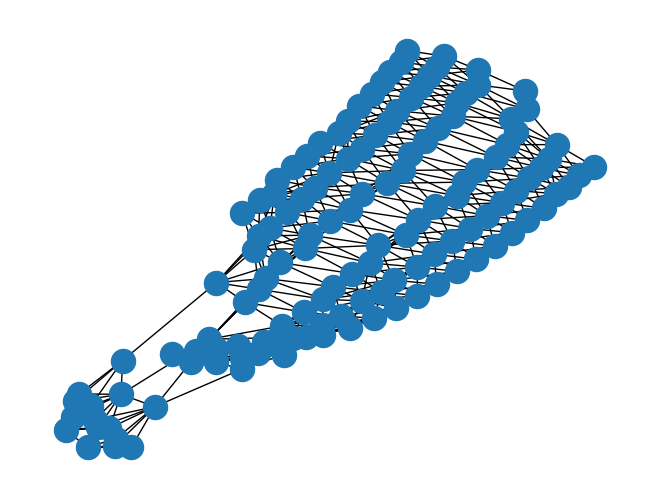

In [13]:
def construct_graph(turbine1, turbine2, max_distance):
    n1 = int(turbine1.TurbID)
    n2 = int(turbine2.TurbID)
    if n1 > n2:
        distance = np.sqrt((turbine2.x - turbine1.x)**2 + (turbine2.y - turbine1.y)**2)
        if distance <= max_distance:
            G.add_edge(n1, n2)
turbines.apply(lambda x: turbines.apply(lambda y: construct_graph(x,y,1500),axis=1),axis=1)
nx.draw(G)

Option B: Add regularization term over time to objective. This is equivalent to disjoint graph-time learning

$$\hat x = \arg\min_x||M\odot(X-Y)||_2^2+\gamma_1||LX||_2^2+\gamma_2||DX||_2^2$$
$$DX = X_{t+1}-X_t$$

In [14]:
def tikhonov_time(X, Y, L, M, D, gamma_1, gamma_2):
    error = torch.norm(torch.mul(M, X-Y))**2 
    return error + gamma_1 * torch.norm(torch.matmul(L, X.T))**2 + gamma_2 * torch.norm(torch.matmul(D, X[:-1]))**2, error

In [15]:
T = int(train_input["T"].max())
D = np.zeros((T-1,T))
np.fill_diagonal(D, -1)
np.fill_diagonal(D[:,1:],1)
D = torch.Tensor(D).to_sparse()

In [20]:
y = train_input.pivot(index="T", columns="TurbID", values="Patv")
y_test = train.pivot(index="T", columns="TurbID", values="Patv")
M = torch.Tensor(y.notna().astype(int).to_numpy())
M_test = torch.Tensor(train.pivot(index="T", columns="TurbID", values="isTest").astype(int).to_numpy()).to_sparse()
Y = torch.Tensor(y.fillna(0).to_numpy())
Y_test = torch.Tensor(y_test.fillna(0).to_numpy())
L = torch.Tensor(nx.laplacian_matrix(G).todense()).to_sparse()
X = torch.randn(y.shape, requires_grad=True)
optimizer = torch.optim.Adam([X], lr=1)
iterations = 1
losses = []
train_errors = []
test_errors = []
test_mask = ~(mask | (train.isna().any(axis=1)))

In [23]:
for _ in range(10000):
    loss, train_error = tikhonov_time(X, Y, L, M, D, 0.1, 0.1)
    train_error /= M.sum()
    loss = loss.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.detach())
    iterations += 1
    test_error = torch.norm(torch.mul(M_test, X.detach()-Y_test))**2 / M_test.sum()
    print(f"Iteration {iterations}, Loss: {loss}, Train error: {train_error}, Test error: {test_error}", end="\r")
    test_errors.append(test_error.detach())
    train_errors.append(train_error.detach())
plt.plot(train_errors)
plt.plot(test_errors)
plt.legend(["Train", "Test"])
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

KeyboardInterrupt: 

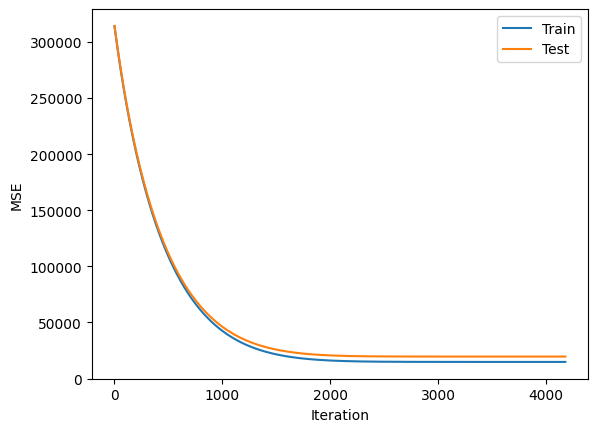

In [24]:
plt.plot(train_errors)
plt.plot(test_errors)
plt.legend(["Train", "Test"])
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

Okay but this graph is only for one time step. We will have to use graph-time learning

Option A: construct a product graph

For now let's focus on a Cartesian product graph. Building the complete graph seems to be infeasible. Building for 100 minutes resulted in graph containing 1600 out of a total 25000 time steps.

In [19]:
graph_filename = "cartesian.edgelist"
if os.path.exists(graph_filename):
    GT = nx.read_edgelist(path=graph_filename, delimiter=":")
else:
    GT = nx.Graph()
    for t in range(train["T"].max()+1):
        GT = nx.union(GT, G, rename=("", f"{t}_"))
        if t > 0:
            for node in G.nodes:
                GT.add_edge(f"{t-1}_{node}", f"{t}_{node}")
    #nx.write_edgelist(GT, path=graph_filename, delimiter=":")

In [20]:
L = nx.laplacian_matrix(GT)
#L = torch.sparse_coo_tensor(L.nonzero(), L.data, L.shape)
type(L)

KeyboardInterrupt: 

In [ ]:
train_subset = train.iloc[:L.shape[0]]
y = np.array(train_subset["Patv"])
type(y)

numpy.ndarray

In [ ]:
M = sp.sparse.diags(train_subset.isna().any(axis=1).astype(int))
type(M)

scipy.sparse._dia.dia_matrix

Torch has no sparse matrix inversion. Switch everything to scipy...

In [ ]:
alpha = 0.1
#x = sp.sparse.linalg.inv(M.T.multiply(M) + alpha * L).multiply(M.T).multiply(M).multiply(y)


# Validation

Option A: Mask known values and check accuracy

Option B: Stability analysis. Plot over hyperparameter